# BBH Postmerger GW Representations

This notebook explores the time-, frequency- and time-frequency representations of BBH merger/post-merger signals


In [1]:
%matplotlib inline
import argparse
import matplotlib

# The following line is added in order to avoid:
# _tkinter.TclError: no display name and no $DISPLAY environment variable,
# which occurs when I convert and run this file in a .py script.
# matplotlib.use('Agg')

import sys, os, h5py
import copy
import numpy as np
from matplotlib import pyplot as plt
import cwt
from scipy.interpolate import interp1d

import lal
import pycbc.waveform as wfutils
from pycbc.waveform import get_td_waveform,taper_timeseries
from pycbc.types import FrequencySeries
from pycbc.filter import sigma as optimal_snr

fig_width_pt = 510.
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

fontsize = 16
legendfontsize = 14

params={'text.usetex': True,
        'axes.labelsize': fontsize,
        'font.size': fontsize,
        'legend.fontsize': legendfontsize,
        'xtick.labelsize': fontsize,
        'ytick.labelsize': fontsize,
        'figure.figsize': fig_size,
        'font.weight': 'normal'
       }


import pylab
pylab.rcParams.update(params)
pylab.rcParams['axes.linewidth'] = 1
pylab.rc('axes', linewidth=1)

def touchbox(ax):
    ax.minorticks_on()
    ax.tick_params('both', length=5, width=1, which='major')
    ax.tick_params('both', length=3.5, width=1, which='minor')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    return

# plt.style.use('seaborn-darkgrid')


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Waveform generation
Read the input numerical relativity data from the HDF5 file and generate the corresponding gravitational wave signal using the parameters in this notebook.


In [2]:
def gen_waveform(iota, phi, numrel_data):
    ## FIXME(Gonghan): It seems that this variable is never used.
    global wavelabel
    wavelabel=os.path.join(savepath, numrel_data.split('/')[-1].replace(".h5",""))

    f = h5py.File(numrel_data, 'r')

    global hp, hc
    hp, hc = get_td_waveform(approximant='NR_hdf5',
                                 numrel_data=numrel_data,
                                 mass1=f.attrs['mass1']*mass,
                                 mass2=f.attrs['mass2']*mass,
                                 spin1z=f.attrs['spin1z'],
                                 spin2z=f.attrs['spin2z'],
                                 delta_t=1.0/sample_frequency,
                                 f_lower=30.,
                                 inclination=iota,
                                 coa_phase=phi,
                                 distance=1000)
    
    '''mode_array=[[2,2], [2,-2]]'''
    
#     print "in gen_waveform, have got hp, hc. iota: {}, phi: {}".format(iota, phi)
#     print hp
#     print hc
    f.close()

    # Taper waveform for smooth FFTs
    hp = taper_timeseries(hp, tapermethod="TAPER_START")
    hc = taper_timeseries(hc, tapermethod="TAPER_START")

    global amp, foft
    amp = wfutils.amplitude_from_polarizations(hp,hc)
    foft = wfutils.frequency_from_polarizations(hp,hc)

    # Shift time origin to merger
    global sample_times
    
    ## FIXME(Gonghan): Not sure how we want to define zero time.
    sample_times = amp.sample_times - amp.sample_times[np.argmax(amp)]
#     sample_times = amp.sample_times

    # # Trim the timeseries before the CWT
    # hp_red = hp[:int(sample_frequency)]

## Time-Frequency Decomposition
Here, we decompose the time series data into a time frequency representation (i.e., image) for image classification.  In this example, we use a [continuous wavelet transform](https://www.mathworks.com/help/wavelet/continuous-wavelet-analysis.html?requestedDomain=true) ("CWT").

In [3]:
def tf_decompose():
    ## FIXME(Gonghan): fmin and fmax are not used in the script.
    fmin=sample_frequency*mother_freq/max_scale
    fmax=sample_frequency*mother_freq

    cwt_result = cwt.build_cwt(hp.data, sample_times, 
                               mother_freq=mother_freq, 
                               max_scale=max_scale)
    
    global wfreqs, wplane
    wfreqs = cwt_result['frequencies']
    wplane = cwt_result['map']

    # Interpolate the spectrogram to a finer frequency grid for smoother plots
    # XXX: worth checking that we don't introduce artifacts here
    interpolant = interp1d(wfreqs, wplane, axis=0)
    wfreqs = np.arange(wfreqs.min(), max_scale)
    wplane = interpolant(wfreqs)

# Producing plots

## Physical units
This set of plots are given in the physical units of the waveform, such that time is in seconds, frequency is in Hertz and gravitational wave strain is dimensionless

In [4]:
def plot_physical(numrel_data, iota, phi, show_plot=True, in_degree=False, save_plot=True):
    print "I am in plot_physical()!"
    print "mother frequency:", mother_freq, "iota:", iota, "phi:", phi
    
    plt.close('all')
    
    fig, ax = plt.subplots(figsize=(fig_width, 2.1*fig_height), 
                           sharex=True, nrows=2)


    #
    # Time series
    #
    a = ax[0].plot(sample_times, hp, label=r'$\Re[h(t)]$')
    b = ax[0].plot(sample_times, amp, label=r'$|h(t)|$')
    ax[0].legend()

    #
    # Spectrogram
    #
    p_qstrain = ax[1].pcolormesh(sample_times, wfreqs, (abs(wplane)),
                              rasterized=False,
                             vmin=0,vmax=1,cmap='gnuplot')

    #
    # Frequency series
    #
    # FIXME: why is frequency negative??
    ax[1].plot(sample_times[:-1], -1*foft, label=r'$\arg[h(t)]$', 
               color='green', linestyle='-')

    ax[1].legend(loc='upper left')

    # XXX Do not delete this, in case we want a colorbar later
#     cbaxes = fig.add_axes([0.1275, 0.9, 0.77, 0.03]) 
#     cbar=fig.colorbar(p_qstrain, orientation='horizontal', cax=cbaxes)
#     cbar.ax.xaxis.set_ticks_position('top')
#     cbar.ax.xaxis.set_label_position('top')
#     ax.clabel(c_qstrain, inline=1, fmt="%.1f", fontsize=14)


    for i in xrange(len(ax)):

        ax[i].set_xlim(-0.05,0.05)

        if i==0:
            ax[i].set_ylabel(r'$\textrm{Strain at 1 Gpc}$')
        if i==1:
            ax[i].set_ylim(0,max_scale)
            ax[i].set_xlabel(r'$\textrm{Time (s)}$')
            ax[i].set_ylabel(r'$\textrm{Frequency (Hz)}$')

        # Beautify the lines
        touchbox(ax[i])

    plt.subplots_adjust(hspace=0)
    
    if save_plot:
        # Determine figure name from numrel file and orientation
        if in_degree:
            figname = os.path.join(savepath,
                                   os.path.basename(numrel_data).replace('.h5', '')
                                   + '_iota-%f' % (iota * 180 / np.pi) 
                                   + '_phi-%f' % (phi * 180 / np.pi) + '.png')
        else:
            figname = os.path.join(savepath,
                                   os.path.basename(numrel_data).replace('.h5', '')
                                   + '_iota-%f' % iota + '_phi-%f' % phi + '.png')
        plt.savefig(figname)
    
    if show_plot:
        plt.show()

## Natural / geometric units
Here we rescale the data such that $$G=c=1$$ and time is in solar masses in seconds, frequency is in units of 1/solar mass and strain amplitude is in solar masses in meters.

In [5]:
def plot_geometric(numrel_data, iota, phi, show_plot=True, in_degree=False, save_plot=True):
    print "I am in plot_geometric()!"
    print "mother frequency:", mother_freq, "iota:", iota, "phi:", phi
    
    mscale_sec=lal.MTSUN_SI*mass
    mscale_mpc=1/ ( lal.MRSUN_SI / ( 1000 * lal.PC_SI * 1.0e6) )

    plt.close('all')
    fig, ax = plt.subplots(figsize=(fig_width, 2.1*fig_height), 
                           sharex=True, nrows=2)


    #
    # Time series
    #
    ax[0].plot(sample_times/mscale_sec, hp*mscale_mpc, label=r'$\Re[h(t)]$')
    a = ax[0].plot(sample_times/mscale_sec, amp*mscale_mpc, label=r'$|h(t)|$')
    ax[0].legend()

    #
    # Spectrogram
    #
    p_qstrain = ax[1].pcolormesh(sample_times/mscale_sec, wfreqs*mscale_sec, 
                                 (abs(wplane)), cmap='gnuplot', 
                                 rasterized=False, vmin=0,vmax=1)

    #
    # Frequency series
    #
    # FIXME: why is frequency negative??
    ax[1].plot(sample_times[:-1]/mscale_sec, -1*foft*mscale_sec, 
               label=r'$\arg[h(t)]$', color='g')

    ax[1].legend(loc='upper left')


    for i in xrange(len(ax)):

        ax[i].set_xlim(-0.05/mscale_sec,0.05/mscale_sec)

        if i==0:
            ax[i].set_ylabel(r'$\textrm{Strain}$')
        if i==1:
            ax[i].set_ylim(10*mscale_sec,max_scale*mscale_sec)
            ax[i].set_xlabel(r'$\textrm{Time }(\textrm{M}_{\odot})$')
            ax[i].set_ylabel(r'$\textrm{Frequency }(1/\textrm{M}_{\odot})$')

        # Beautify the lines
        touchbox(ax[i])

    plt.subplots_adjust(hspace=0)

    if save_plot:
        if in_degree:
            figname = os.path.join(savepath,
                                   os.path.basename(numrel_data).replace('.h5', '')
                                   + '_iota-%f' % (iota * 180 / np.pi)
                                   + '_phi-%f' % (phi * 180 / np.pi) + '_GEOM.png')
        else:
            figname = os.path.join(savepath,
                                   os.path.basename(numrel_data).replace('.h5', '')
                                   + '_iota-%f' % iota + '_phi-%f' % phi + '_GEOM.png')
        plt.savefig(figname)
    
    if show_plot:
        plt.show()

## Generate time-frequency maps
Generate physical and geometric time-frequency maps for multiple combinations of the inclination angle and the phase angle.

In [6]:
# Helper function that checks whether a number is essentially an integer.
# This number can be float or int.
def is_int(x):
    x = float(x)
    return x == float(np.floor(x))

# Helper function that generates the time-frequency maps (phyical and geometric units) 
# for one numrel simulation at a pair of inclination angle and phase angle.
def gen_one_map(iota, phi, numrel_data, name_in_degree, show_plot=False, save_plot=True):
    gen_waveform(iota, phi, numrel_data)
    tf_decompose()
    plot_physical(numrel_data, iota, phi, show_plot=show_plot, in_degree=name_in_degree, 
                  save_plot=save_plot)
#     plot_geometric(numrel_data, iota, phi, show_plot=show_plot, in_degree=name_in_degree, 
#                    save_plot=save_plot)

# Helper function that checks if step - start == an integer * step.
# It also does basic sanity checks.
def check_step(start, end, step, var_name, bound=None):
    if start < 0 or end < 0 or step < 0:
        raise Exception("Not all input angles of {} are non-negative.".format(var_name))
    if start > end:
        raise Exception("End value of {} is smaller than start value.".format(var_name))
    if bound != None:
        if end > bound:
            raise Exception("End value of {} cannot be larger than {}.".format(var_name, bound))
    
    if float(step) == 0.0:
    # Avoiding zero division error.
        if not float(end - start) == 0.0:
            raise Exception("Step of {} is not consistent.".format(var_name))
    else:
        num_steps = float(end - start) / step
        if not is_int(num_steps):
            raise Exception("Step of {} is not consistent.".format(var_name))

# This function generates and saves a set of time-frequency maps for a set of 
# inclination and phase angles.
def gen_maps(iota_start, iota_end, iota_step, phi_start, phi_end, phi_step, name_in_degree, 
             save_plot=True, show_plot=False):
    # Checking whether the steps of iota and phi are consistent with the respective start and end values.
    check_step(iota_start, iota_end, iota_step, "iota")
    check_step(phi_start, phi_end, phi_step, "phi")
    
    for numrel_data in numrel_data_list:
        iota = iota_start
        while iota <= iota_end:
            phi = phi_start
            while phi <= phi_end:
#                 print "current numrel_data: ", numrel_data, "iota: ", iota, "phi:", phi
                gen_one_map(iota, phi, numrel_data, name_in_degree, save_plot=save_plot, show_plot=show_plot)
#                 print ""
                phi += phi_step
                
                # In case of phi_step == 0
                if phi == phi_start:
                    break     
            iota += iota_step
     
            # In case ofiota_step == 0
            if iota == iota_start:
                break


## Configuration
The following sections define where to save data, the BBH waveform to generate and the resolution of our time-frequency maps, generated via continuous wavelet transforms.

### Waveform configuration
 * `mass`: total mass of the system in solar masses
 * `sample_frequency`: frequency with which the digitized time-series is sampled.  Time spacing between samples is `1/sample_frequency`


In [7]:
# mass=100
mass = 100
sample_frequency = 4096

### Orientation
 * `phi`: coalescence phase; determined by the azimuthal angle around the system
 * `iota`: inclination of orbital plane with respect to the line-of-sight, *at the start of the simulation*


In [8]:
# The following lines of code are not used for now.
# phi=0.0
# iota=0.0

### File Configuration
 * `savepath`: figures will be saved to this directory of the container
 * `numrel_data_list`: The numerical relativity simulations to use

### Generating time-frequency maps
This section generates the time-frequency maps for specified angles.

### Time-frequency Decomposition
This section determines the range of frequencies we observe, and the resolution of the time-frequency maps.
 * `mother_freq`: frequency of the mother wavelet
 * `max_scale`: maximum wavelet scale
Note that the frequency space of the spectrogram is given by:
```
fmin=sample_frequency*mother_freq/max_scale
fmax=sample_frequency*mother_freq
```

I am in plot_physical()!
mother frequency: 0.5 iota: 1.57079632679 phi: 3.14159265359


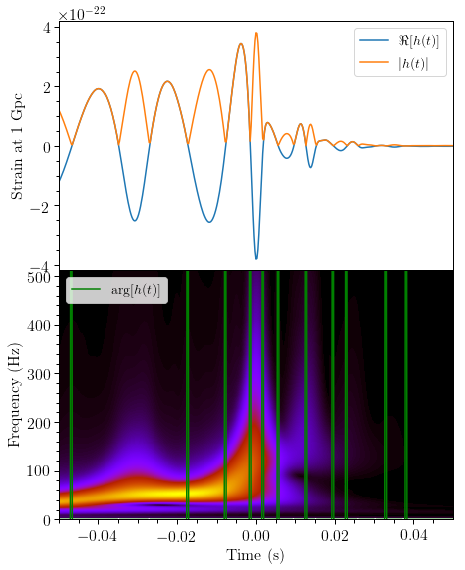

In [10]:
pi = np.pi

# parser = argparse.ArgumentParser()
# parser.add_argument("filepath", help="absolute path of the .h5 waveform file that you \
#                     want to generate your time-frequency map from.")
# parser.add_argument("savepath", help="the absolute path for the directory where the generated plots are saved.")
# parser.add_argument("iota_start", type=float, help="the starting value of the inclination angle.")
# parser.add_argument("iota_end", type=float, help="the ending value of the inclination angle.")
# parser.add_argument("iota_step", type=float, help="the step value of the inclination angle.")
# parser.add_argument("phi_start", type=float, help="the starting value of the phase angle.")
# parser.add_argument("phi_end", type=float, help="the ending value of the phase angle.")
# parser.add_argument("phi_step", type=float, help="the step value of the phase angle.")
# parser.add_argument("-r", "--rad", action="store_true", help="Optional argument to specify whether \
#                     you want to input the angles in radians. If not specfied, the input angles \
#                     are default to degrees. If you specify the angles in radians, you should input \
#                     the angles as fractions of pi, without inputting the symbol pi itself.")

# args = parser.parse_args()
# if not args.rad:
#     iota_start, iota_end, iota_step = args.iota_start*pi/180, args.iota_end*pi/180, args.iota_step*pi/180
#     phi_start, phi_end, phi_step = args.phi_start*pi/180, args.phi_end*pi/180, args.phi_step*pi/180
#     check_step(iota_start, iota_end, iota_step, "iota", 2*pi)
#     check_step(phi_start, phi_end, phi_step, "phi", 2*pi)
#     name_in_degree = True
    
# else:
#     iota_start, iota_end, iota_step = args.iota_start * pi, args.iota_end * pi, args.iota_step * pi
#     phi_start, phi_end, phi_step = args.phi_start * pi, args.phi_end * pi, args.phi_step * pi
#     check_step(iota_start, iota_end, iota_step, "iota", 2*pi)
#     check_step(phi_start, phi_end, phi_step, "phi", 2*pi)
#     name_in_degree = False
    
# savepath = args.savepath
# filepath = args.filepath
# numrel_data_list = [filepath]

# Transform parameters
# mother_freq was originally 0.5.
mother_freq = 1
max_scale=512

savepath = "/bbh-tfmaps/testplots"
numrel_data_list=["/waves/GT0370.h5", "/waves/GT0448.h5", "/waves/GT0476.h5", "/waves/GT0477.h5", 
                  "/waves/GT0564.h5", "/waves/GT0577.h5", "/waves/GT0621.h5", "/waves/GT0622.h5", 
                  "/waves/GT0650.h5", "/waves/GT0651.h5", "/waves/GT0818.h5", "/waves/GT0900.h5"]
numrel_data_list=["/waves/GT0577.h5"]

iota, phi = pi/2, pi

iota_start, iota_end, iota_step = iota, iota, 0
phi_start, phi_end, phi_step = phi, phi, 0
name_in_degree = False

# Notice that the iota and phi values supplied to gen_maps are always in radian.
for mother_freq in np.linspace(0.5, 0.5, 1):
    gen_maps(iota_start, iota_end, iota_step,
             phi_start, phi_end, phi_step, name_in_degree, save_plot=False, show_plot=True)
